# Tabnet Hyperoptimization

In [1]:
import pandas as pd
from load_data import *
from matplotlib import pyplot as plt
%matplotlib inline
import tabnet
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import os
import seaborn as sns 
%matplotlib inline
from sklearn.model_selection import KFold

In [2]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  
  return r2

In [3]:
def transform(ds):
    features = tf.unstack(ds["features"])
    prices = ds["price"]

    x = dict(zip(col_names, features))
    y = prices
    return x, y

## Selected Variables

### Output and Feature Dimension
Output and Feature dimension have a large impact on performance, so do the optimization only concerning them

In [4]:
X_train, X_test, X_val, y_train, y_test, y_val = load_data(for_dendro = False)

------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blanke

In [5]:
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])

In [6]:
bin_col = [col for col in X_train if np.isin(X_train[col].unique(), [0, 1]).all()]
num_col = [col for col in X_train if ~np.isin(X_train[col].unique(), [0, 1]).all()]
col_names = bin_col + num_col

What I want to Grid search for

In [7]:
ods = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120] 
fds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
fds_ind = (np.array(ods) + np.array(fds)).tolist() # for a better labeling of the resulting heatmap
overview_mae = pd.DataFrame(np.zeros((len(ods), len(fds))))
overview_mse = pd.DataFrame(np.zeros((len(ods), len(fds))))
overview_r2 = pd.DataFrame(np.zeros((len(ods), len(fds))))
overview_mae.columns = fds_ind
overview_mae.index = ods
overview_mse.columns = fds_ind
overview_mse.index = ods
overview_r2.columns = fds_ind
overview_r2.index = ods

In [8]:
for i in ods:
    for j in fds:
        
        mae_min = []
        mse_min = []
        r2_max = []

        kf = KFold(n_splits=5, shuffle=True, random_state=1234)
        for train_index, test_index in kf.split(X_train):
            print("TRAIN:", train_index, "TEST:", test_index)
            X_train_kf, X_val_kf = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
            y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[test_index]

            train_size = int(X_train_kf.shape[0] * 0.9)
            batch_size = int(X_train_kf.shape[0] * 0.1)

            data_train = tf.data.Dataset.from_tensor_slices({"features": X_train_kf, "price": y_train_kf})
            data_train = data_train.shuffle(6000, seed = 13)
            train_dataset = data_train.take(len(X_train_kf))
            train_dataset = train_dataset.map(transform)
            train_dataset = train_dataset.batch(batch_size)

            data_test = tf.data.Dataset.from_tensor_slices({"features": X_val_kf, "price": y_val_kf})
            test_dataset = data_test.take(len(X_val_kf))
            test_dataset = test_dataset.map(transform)
            test_dataset = test_dataset.batch(batch_size)

            feature_columns = []

            for col in col_names:
                feature_columns.append(tf.feature_column.numeric_column(col))

            model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                            output_dim=i, feature_dim=i+j, num_groups=1,
                                            num_decision_steps=2)
                                            
            lr = 0.01
            optimizer = tf.keras.optimizers.Adam(lr)
            model.compile(optimizer, loss=['mse', "mae"] , metrics=[R_squared, "mse", "mae"])

            hist_model = model.fit(train_dataset, epochs=50, 
                                validation_data=test_dataset, verbose=1)

            mae_min.append(np.min(hist_model.history["val_mae"]))
            mse_min.append(np.min(hist_model.history["val_mse"]))
            r2_max.append(np.max(hist_model.history["val_R_squared"]))


        mae_min_m = np.mean(mae_min)
        mse_min_m = np.mean(mse_min)
        r2_max_m = np.mean(r2_max)

    overview_mae.at[i, j] = mae_min_m
    overview_mse.at[i, j] = mse_min_m
    overview_r2.at[i, j] = r2_max_m

TRAIN: [   1    2    3 ... 5309 5310 5311] TEST: [   0    8   14 ... 5301 5302 5306]
[TabNet]: 1 features will be used for decision steps.
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 2s 225ms/step - loss: 6.7287 - R_squared: -13.3807 - mse: 6.7287 - mae: 2.0818 - val_loss: 1.1313 - val_R_squared: -1.4261 - val_mse: 1.1313 - val_mae: 0.8951
Epoch 2/50
11/11 [==============================] - 1s 74ms/step - loss: 0.6599 - R_squared: -0.5383 - mse: 0.6599 - mae: 0.6578 - val_loss: 0.4706 - val_R_sq

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


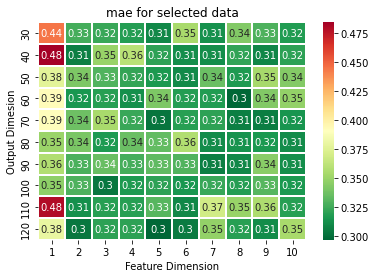

In [ ]:
sns.heatmap(overview_mae, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for selected data")
plt.xlabel("Feature Dimension")
plt.ylabel("Output Dimesion")
plt.savefig("TabNet_selected_GS_mae_NEW", drpi = 300)

In [ ]:
sns.heatmap(overview_mse, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for selected data")
plt.xlabel("Feature Dimension")
plt.ylabel("Output Dimesion")
plt.savefig("TabNet_selected_GS_mse_NEW", drpi = 300)

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


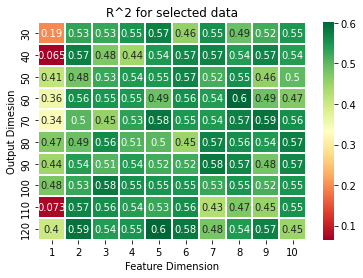

In [ ]:
sns.heatmap(overview_r2, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for selected data")
plt.xlabel("Feature Dimension")
plt.ylabel("Output Dimesion")
plt.savefig("TabNet_selected_GridSearch_r2_NEW", drpi = 300)

In [ ]:
overview_mae.to_csv("GS_mae_selected_NEW.csv")
overview_mse.to_csv("GS_mse_selected_NEW.csv")
overview_r2.to_csv("GS_R2_selected_NEW.csv")

In [16]:
overview_r2.loc[60,8]

0.601468026638031

In [17]:
overview_r2.loc[120,5]

0.6008834838867188

Choose output_dim = 60 und feature_dim = 68 as best model.
Now steps and relaxation factor.

In [9]:
od = ???
fd = ???
nds = [2, 3, 4, 5, 6, 7, 8, 9, 10]
rf = [1, 1.5, 2, 2.5, 3, 3.5]

In [11]:
overview_mae_2 = pd.DataFrame(np.zeros((len(nds), len(rf))))
overview_mse_2 = pd.DataFrame(np.zeros((len(nds), len(rf))))
overview_r2_2 = pd.DataFrame(np.zeros((len(nds), len(rf))))
overview_mae_2.columns = rf
overview_mae_2.index = nds
overview_mse_2.columns = rf
overview_mse_2.index = nds
overview_r2_2.columns = rf
overview_r2_2.index = nds

In [ ]:
for i in nds:
    for j in rf:
        
        mae_min = []
        mse_min = []
        r2_max = []

        for train_index, test_index in kf.split(X_train):
            print("TRAIN:", train_index, "TEST:", test_index)
            X_train_kf, X_val_kf = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
            y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[test_index]

            train_size = int(X_train_kf.shape[0] * 0.9)
            batch_size = int(X_train_kf.shape[0] * 0.1)

            data_train = tf.data.Dataset.from_tensor_slices({"features": X_train_kf, "price": y_train_kf})
            data_train = data_train.shuffle(6000, seed = 13)
            train_dataset = data_train.take(len(X_train_kf))
            train_dataset = train_dataset.map(transform)
            train_dataset = train_dataset.batch(batch_size)

            data_test = tf.data.Dataset.from_tensor_slices({"features": X_val_kf, "price": y_val_kf})
            test_dataset = data_test.take(len(X_val_kf))
            test_dataset = test_dataset.map(transform)
            test_dataset = test_dataset.batch(batch_size)

            feature_columns = []

            for col in col_names:
                feature_columns.append(tf.feature_column.numeric_column(col))

            model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                            output_dim=od, feature_dim=fd, num_groups=1,
                                            num_decision_steps=i, relaxation_factor=j)
                                            
            lr = 0.01
            optimizer = tf.keras.optimizers.Adam(lr)
            model.compile(optimizer, loss=['mse', "mae"] , metrics=[R_squared, "mse", "mae"])

            hist_model = model.fit(train_dataset, epochs=100, 
                                validation_data=test_dataset, verbose=1)

            mae_min.append(np.min(hist_model.history["val_mae"]))
            mse_min.append(np.min(hist_model.history["val_mse"]))
            r2_max.append(np.max(hist_model.history["val_R_squared"]))


        mae_min_m = np.mean(mae_min)
        mse_min_m = np.mean(mse_min)
        r2_max_m = np.mean(r2_max)

    overview_mae_2.at[i, j] = mae_min_m
    overview_mse_2.at[i, j] = mse_min_m
    overview_r2_2.at[i, j] = r2_max_m

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


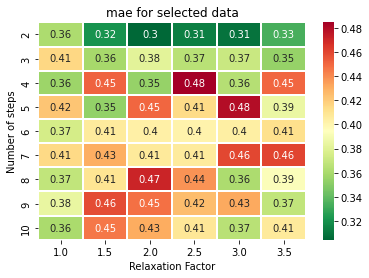

In [14]:
sns.heatmap(overview_mae_2, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for selected data")
plt.xlabel("Relaxation Factor")
plt.ylabel("Number of steps")
plt.savefig("TabNet_selected_GS_mae_2_NEW", drpi = 300)

In [ ]:
sns.heatmap(overview_mse_2, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for selected data")
plt.xlabel("Relaxation Factor")
plt.ylabel("Number of steps")
plt.savefig("TabNet_selected_GS_mse_2_NEW", drpi = 300)

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


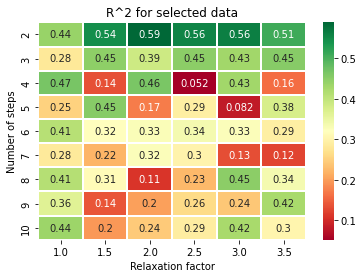

In [15]:
sns.heatmap(overview_r2_2, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for selected data")
plt.xlabel("Relaxation factor")
plt.ylabel("Number of steps")
plt.savefig("TabNet_selected_GridSearch_r2_2_NEW", drpi = 300)

In [17]:
overview_r2_2.loc[2,2]

0.5881540775299072

In [18]:
overview_mae_2.to_csv("GS_mae_nds_rf_selected_NEW.csv")
overview_mse_2.to_csv("GS_mae_nds_rf_selected_NEW.csv")
overview_r2_2.to_csv("GS_R2_nds_rf_selected_NEW.csv")

In [198]:
nds = ???
rf = ???
sc = [ 1e-2, 1e-3, 1e-4, 1e-5]
overview_mae_3 = pd.DataFrame(np.zeros((1, len(sc))))
overview_r2_3 = pd.DataFrame(np.zeros((1, len(sc))))
overview_mae_3.columns = sc
overview_r2_3.columns = sc

In [199]:
for j in sc:
    model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                        output_dim=od, feature_dim=fd, num_groups=1,
                                         num_decision_steps=nds, relaxation_factor=rf,
                                         sparsity_coefficient=j)
    lr = 0.01
    optimizer = tf.keras.optimizers.Adam(lr)
    model.compile(optimizer, loss=['mse', "mae"] , metrics=[R_squared, "mse", "mae"])

    hist_model = model.fit(train_dataset, epochs=100, 
                               validation_data=test_dataset, verbose=1)
                               
    mae_min = np.min(hist_model.history["val_mae"])
    r2_max = np.max(hist_model.history["val_R_squared"])

    overview_mae_3.at[0, j] = mae_min
    overview_r2_3.at[0, j] = r2_max

[TabNet]: 8 features will be used for decision steps.
Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 3s 247ms/step - loss: 3.6474 - R_squared: -6.8813 - mse: 3.6474 - mae: 1.3245 - val_loss: 0.3564 - val_R_squared: 0.1057 - val_mse: 0.3564 - val_mae: 0.4827
Epoch 2/100
11/11 [==============================] - 1s 88ms/step - loss: 0.3123 - R_squared: 0.3020 - mse: 0.3123 - mae: 0.4340 - val_loss: 0.2829 - val_R_squared: 0.2890 - val_mse: 0.2829 - val_mae: 0.4097
Epoch 3/100
11/11 [=================

Text(33.0, 0.5, '')

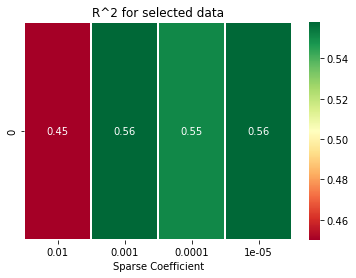

In [200]:
sns.heatmap(overview_r2_3, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for selected data")
plt.xlabel("Sparse Coefficient")
plt.ylabel("")


C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


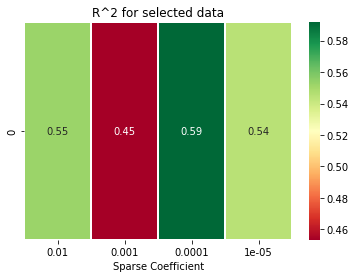

In [23]:
sns.heatmap(overview_r2_3, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for selected data")
plt.xlabel("Sparse Coefficient")
plt.ylabel("")
plt.savefig("TabNet_selected_GridSearch_r2_3", drpi = 300)

# Final Model
od = 60
fd = 68
nds = 2
rf = 2
sc = 1e-4

In [214]:
od = 60
fd = 68
nds = 2
rf = 2
epo = 100

In [215]:
perf = 0

In [222]:
while perf < 0.6:
    #lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=200, decay_rate=0.95, staircase=False)
    lr = 0.01
    optimizer = tf.keras.optimizers.Adam(lr)

    model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                    output_dim=od, feature_dim=fd, num_groups=1,
                                    num_decision_steps=nds, relaxation_factor=rf)

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="TabNet_GS/best_model.hdf5",
                                                    monitor='val_R_squared',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    mode='max')

    model.compile(optimizer, loss=['mse', "mae"] , metrics=[R_squared, "mse", "mae"])

    hist_model = model.fit(train_dataset, epochs=epo, 
                           validation_data=test_dataset, verbose=1,
                           callbacks=[checkpoint])

    perf = np.max(hist_model.history["val_R_squared"])
    print(perf)

[TabNet]: 8 features will be used for decision steps.
Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

6/7 [========================>.....] - ETA: 0s - loss: 5.8525 - R_squared: -12.9600 - mse: 5.8525 - mae: 1.8869
Epoch 00001: val_R_squared improved from -inf to -1.07812, saving model to TabNet_GS\best_model.hdf5
7/7 [==============================] - 2s 297ms/step - loss: 5.3513 - R_squared: -11.2285 - mse: 5.3513 - mae: 1.7742 - val_loss: 0.8255 - val_R_squared: -1.0781 - val_mse: 0.8255 - val_mae: 0.7433
Epoch 2/100
6/7 [==============

KeyboardInterrupt: 

In [117]:
hist_df = pd.DataFrame(hist_model.history)
hist_csv_file = 'history_TabNet_Selected.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

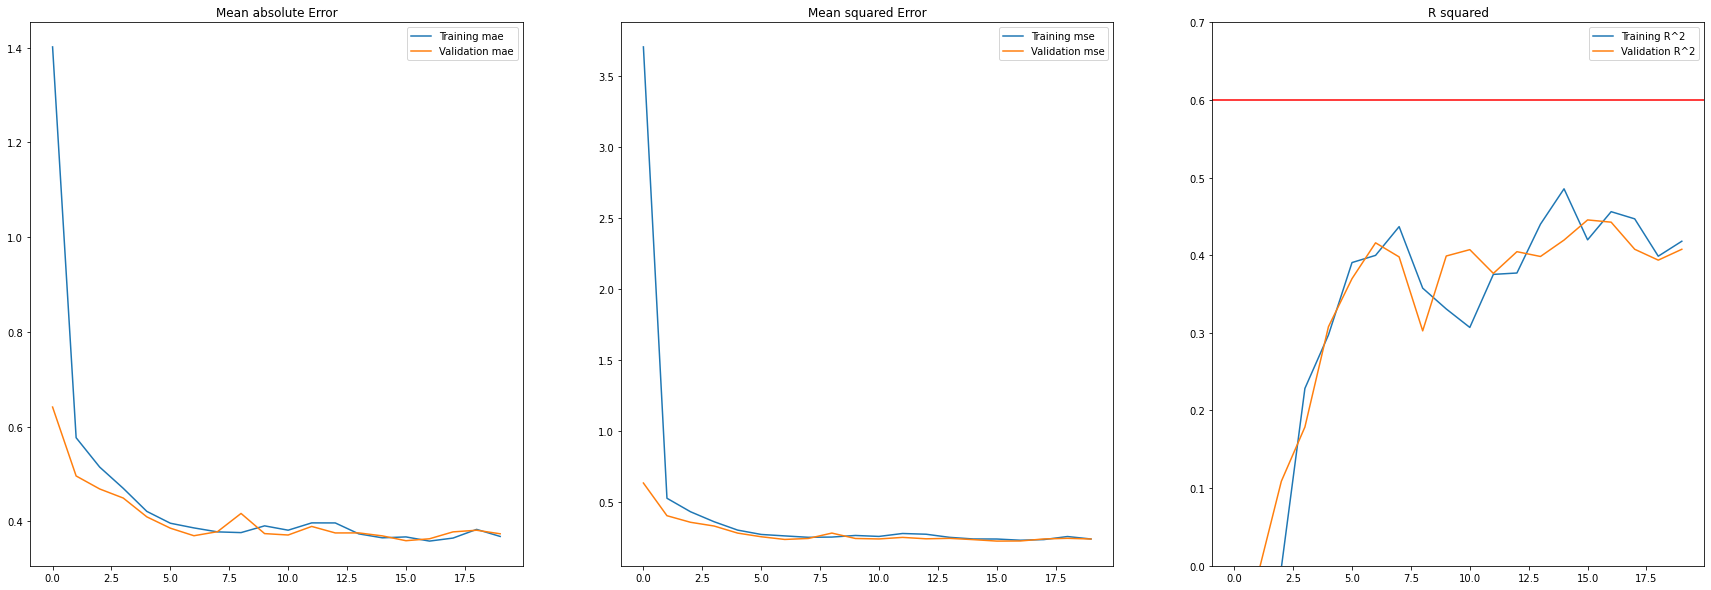

In [118]:
epochs_range = range(epo)
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
axs[0].plot(epochs_range, hist_model.history["mae"], label="Training mae")
axs[0].plot(epochs_range, hist_model.history["val_mae"], label="Validation mae")
axs[0].set_title("Mean absolute Error")
axs[0].legend(loc='best')

axs[1].plot(epochs_range, hist_model.history["mse"], label="Training mse")
axs[1].plot(epochs_range, hist_model.history["val_mse"], label="Validation mse")
axs[1].set_title("Mean squared Error")
axs[1].legend(loc='best')

axs[2].plot(epochs_range, hist_model.history["R_squared"], label="Training R^2")
axs[2].plot(epochs_range, hist_model.history["val_R_squared"], label="Validation R^2")
axs[2].set_ylim((0, 0.7))
axs[2].set_title("R squared")
axs[2].axhline(y = 0.6, color = "red")
axs[2].legend(loc='best')


In [119]:
np.max(hist_model.history["val_R_squared"])

0.4453851878643036

In [120]:
# Graph, prüfen, ob 60 erreicht wurde, etc.

In [180]:
model.load_weights("TabNet_GS/best_model.hdf5")